### Importing

In [53]:
# pip install -r ../python_requirements.txt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import requests
import time
import io

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

In [2]:
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Setup and Cleaning

In [3]:
url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'

In [4]:
response = requests.get(url)
content = response.content

read_file = pd.read_csv(io.BytesIO(content), sep=",", compression="gzip", index_col=0, quotechar='"',header=None)
kdd_df = pd.DataFrame(read_file)

In [5]:
kdd_df.head()

,1,2,3,4,5,6,7,8,9,10,...,32,33,34,35,36,37,38,39,40,41
0,,,,,,,,,,,,,,,,,,,,,
0,tcp,http,SF,181,5450,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,235,1337,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,219,1337,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,217,2032,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [6]:
kdd_df.reset_index(inplace=True)
kdd_df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
#import column names and start cleaning them 
with open('kdd_names.txt') as f:
    kdd_cols = f.readlines()
    
for i in range(1,len(kdd_cols)):
    kdd_cols[i] = kdd_cols[i].split(':')[0].strip()
    
kdd_cols.append('connection_type')

attack_types = kdd_cols.pop(0)
attack_types = attack_types.split(',')
attack_types[-1] = attack_types[-1].replace('.\n','')

print('KDD columns:', '\n',kdd_cols, '\n'*2+ 
      'List of attack types:','\n',attack_types)

KDD columns: 
 ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'connection_type'] 

List of attack types: 
 ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', '

In [8]:
#set correct columns
kdd_df.columns = kdd_cols
kdd_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [9]:
kdd_df.connection_type.value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: connection_type, dtype: int64

In [10]:
#clean connection types
kdd_df.connection_type = kdd_df.connection_type.apply(lambda x: x.replace('.',''))
kdd_df.connection_type.unique

<bound method Series.unique of 0         normal
1         normal
2         normal
3         normal
4         normal
           ...  
494016    normal
494017    normal
494018    normal
494019    normal
494020    normal
Name: connection_type, Length: 494021, dtype: object>

In [11]:
#read attack types and their respective category
connections_df = pd.read_csv('training_attack_types.txt',sep=' ',header=None)
connections_df.columns = ['type','category']

#normal connections are not listed in this .txt file so we add them
connections_df = connections_df.append({'type':'normal','category':'normal'},ignore_index=True)
connections_df.head()

,type,category
0,back,dos
1,buffer_overflow,u2r
2,ftp_write,r2l
3,guess_passwd,r2l
4,imap,r2l


In [12]:
#create dict of connection type and resp. category
connections_dict = {}

for i in range(len(connections_df)):
    row = connections_df.iloc[i]
    key = row['type']
    val = row['category']
    
    connections_dict[key] = val
    
connections_dict

{'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'normal': 'normal'}

In [13]:
#map each connection to its category
kdd_df['connection_category'] = kdd_df['connection_type'].apply(lambda x: connections_dict[x])
kdd_df[['connection_type','connection_category']].value_counts()

connection_type  connection_category
smurf            dos                    280790
neptune          dos                    107201
normal           normal                  97278
back             dos                      2203
satan            probe                    1589
ipsweep          probe                    1247
portsweep        probe                    1040
warezclient      r2l                      1020
teardrop         dos                       979
pod              dos                       264
nmap             probe                     231
guess_passwd     r2l                        53
buffer_overflow  u2r                        30
land             dos                        21
warezmaster      r2l                        20
imap             r2l                        12
rootkit          u2r                        10
loadmodule       u2r                         9
ftp_write        r2l                         8
multihop         r2l                         7
phf              r2l   

In [14]:
97278/len(kdd_df)*100

19.691065764410826

Our dataset seems to be predominantly made up of attacks. Normal connections account for only 19.7% of all connection types, with most connections being dos attacks. This is somewhat unrealistic for a real dataset as we would typically expect a larger magnitude of normal connections relative to other connection types.<br></br>

A breakdown by categories is seen below:

In [15]:
kdd_df['connection_category'].value_counts()

dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: connection_category, dtype: int64

In [16]:
kdd_df.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
duration,494021.0,47.979302,707.746472,0.0,0.0,0.0,0.0,58329.0
src_bytes,494021.0,3025.610296,988218.101045,0.0,45.0,520.0,1032.0,693375640.0
dst_bytes,494021.0,868.532425,33040.001252,0.0,0.0,0.0,0.0,5155468.0
land,494021.0,0.000045,0.006673,0.0,0.0,0.0,0.0,1.0
wrong_fragment,494021.0,0.006433,0.134805,0.0,0.0,0.0,0.0,3.0


We now look at columns that contain single values and thus present no variation between our observations with the intention of dropping them to reduce our number of dimensions.

In [17]:
for col in kdd_df.columns:
    if kdd_df[col].nunique() == 1:
        print(col)

num_outbound_cmds
is_host_login


In [18]:
useless_cols = []

for col in kdd_df.columns:
    #number of unique values in that column
    if kdd_df[col].nunique()==1:
        print(col)
        print(kdd_df[col].value_counts())
        print()
        #create record of useless columns
        useless_cols.append(col)

num_outbound_cmds
0    494021
Name: num_outbound_cmds, dtype: int64

is_host_login
0    494021
Name: is_host_login, dtype: int64



In [19]:
#remove the columns inplace
for col in useless_cols:
    kdd_df.drop(col,axis=1,inplace=True)

In [20]:
#41 instead of 43 columns
len(kdd_df.columns)

41

In [21]:
binary_cols = []

for col in kdd_df.columns:
    #
    if kdd_df[col].nunique()==2:
        print(col)
        print(kdd_df[col].value_counts())
        print()

        binary_cols.append(col)

land
0    493999
1        22
Name: land, dtype: int64

logged_in
0    420784
1     73237
Name: logged_in, dtype: int64

root_shell
0    493966
1        55
Name: root_shell, dtype: int64

is_guest_login
0    493336
1       685
Name: is_guest_login, dtype: int64



In [22]:
for col in binary_cols:
    pos_rows = kdd_df[kdd_df[col]==1]
    print('---',col,'---')
    print(pos_rows['connection_type'].value_counts())
    print()

--- land ---
land      21
normal     1
Name: connection_type, dtype: int64

--- logged_in ---
normal             69939
back                2203
warezclient         1020
buffer_overflow       30
loadmodule             8
ftp_write              6
satan                  6
rootkit                5
phf                    4
multihop               4
ipsweep                4
perl                   3
warezmaster            2
spy                    1
imap                   1
guess_passwd           1
Name: connection_type, dtype: int64

--- root_shell ---
normal             23
buffer_overflow    18
phf                 4
perl                3
loadmodule          3
multihop            2
rootkit             2
Name: connection_type, dtype: int64

--- is_guest_login ---
normal          371
warezclient     307
warezmaster       2
multihop          2
ftp_write         2
guess_passwd      1
Name: connection_type, dtype: int64



In [23]:
len(kdd_df[kdd_df.connection_type=='land'])

21

Land column seems like flag for land attacks (in fact it captures all land attacks) and therefore we drop it.

In [24]:
kdd_df.drop('land',axis=1,inplace=True)

In [25]:
len(kdd_df.columns)

40

### Exploration

In [26]:
kdd_df.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,0.000111,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,0.010551,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
#extract all numerical non-binary columns 
kdd_num_cols = [col for col in kdd_df.describe().columns if col not in binary_cols]

#create a dataframe copy using only these columns for exploration
kdd_num_df = kdd_df[kdd_num_cols].copy().astype(float)
kdd_num_df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,181.0,5450.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,9.0,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0.0,239.0,486.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,19.0,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0.0,235.0,1337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.0,29.0,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0.0,219.0,1337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.0,39.0,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0.0,217.0,2032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.0,49.0,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


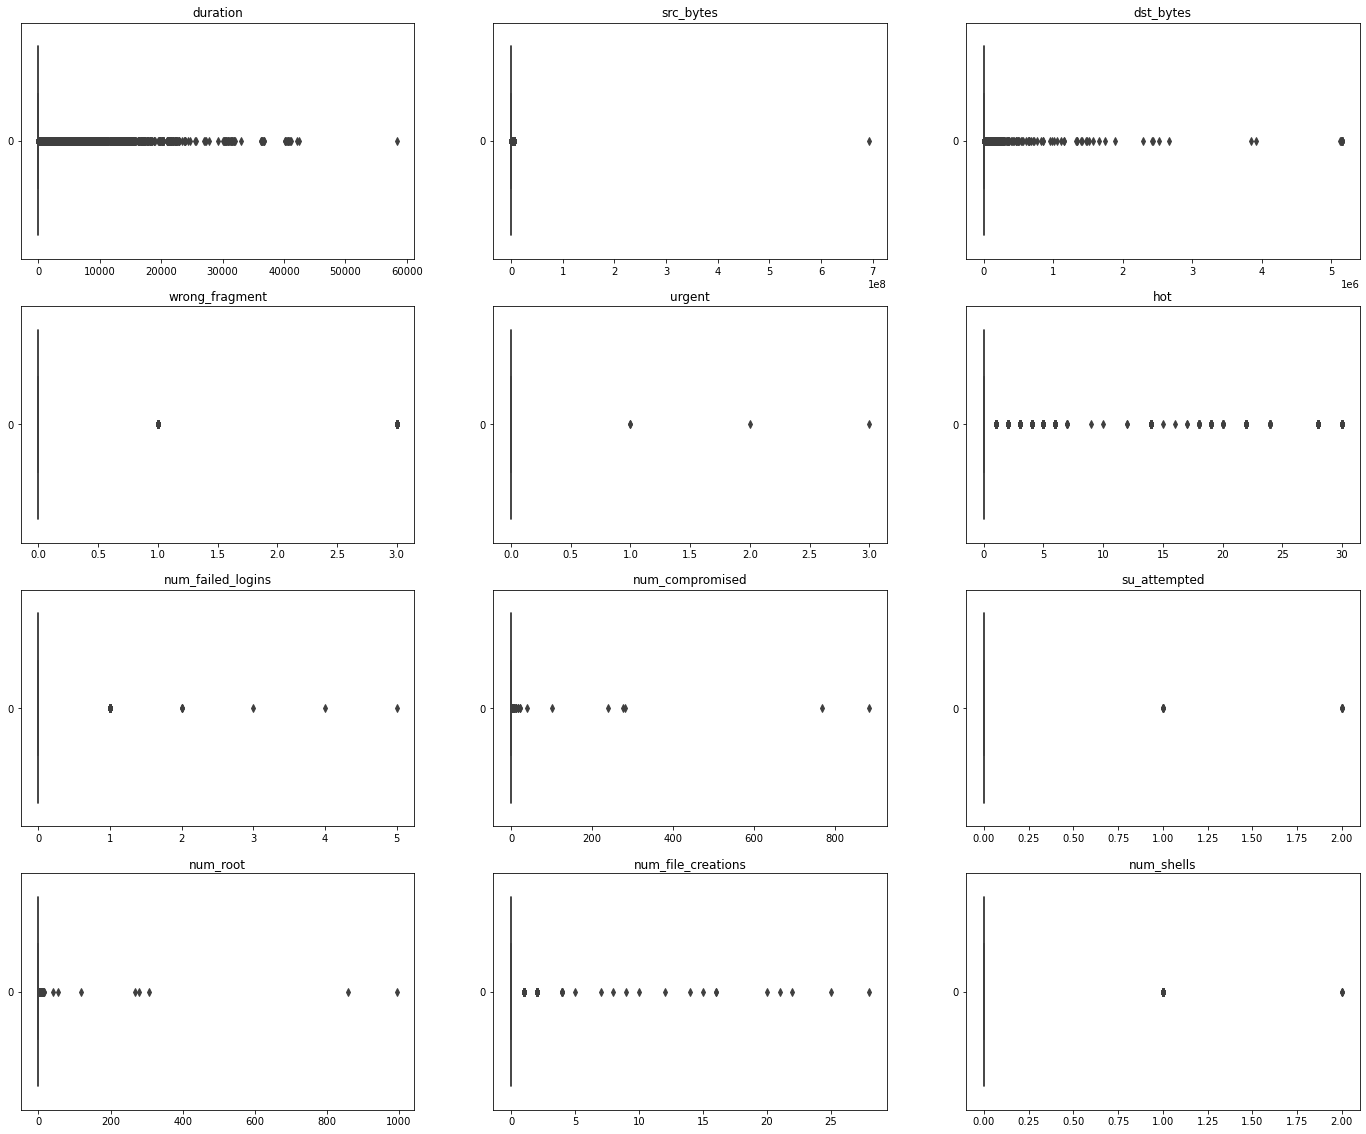

In [28]:
#we plot 12 of our numerical columns at a time so that they are readable and so that we can inspect any possible outliers
fig,axs = plt.subplots(nrows=4,ncols=3,figsize=(24,20))

pos = 0

for col in kdd_num_df.columns[:12]:    
    i = pos//3
    j = pos%3 
    sns.boxplot(data=kdd_num_df[col],orient='h',ax=axs[i][j])
    axs[i][j].set_title(col)
    pos+=1

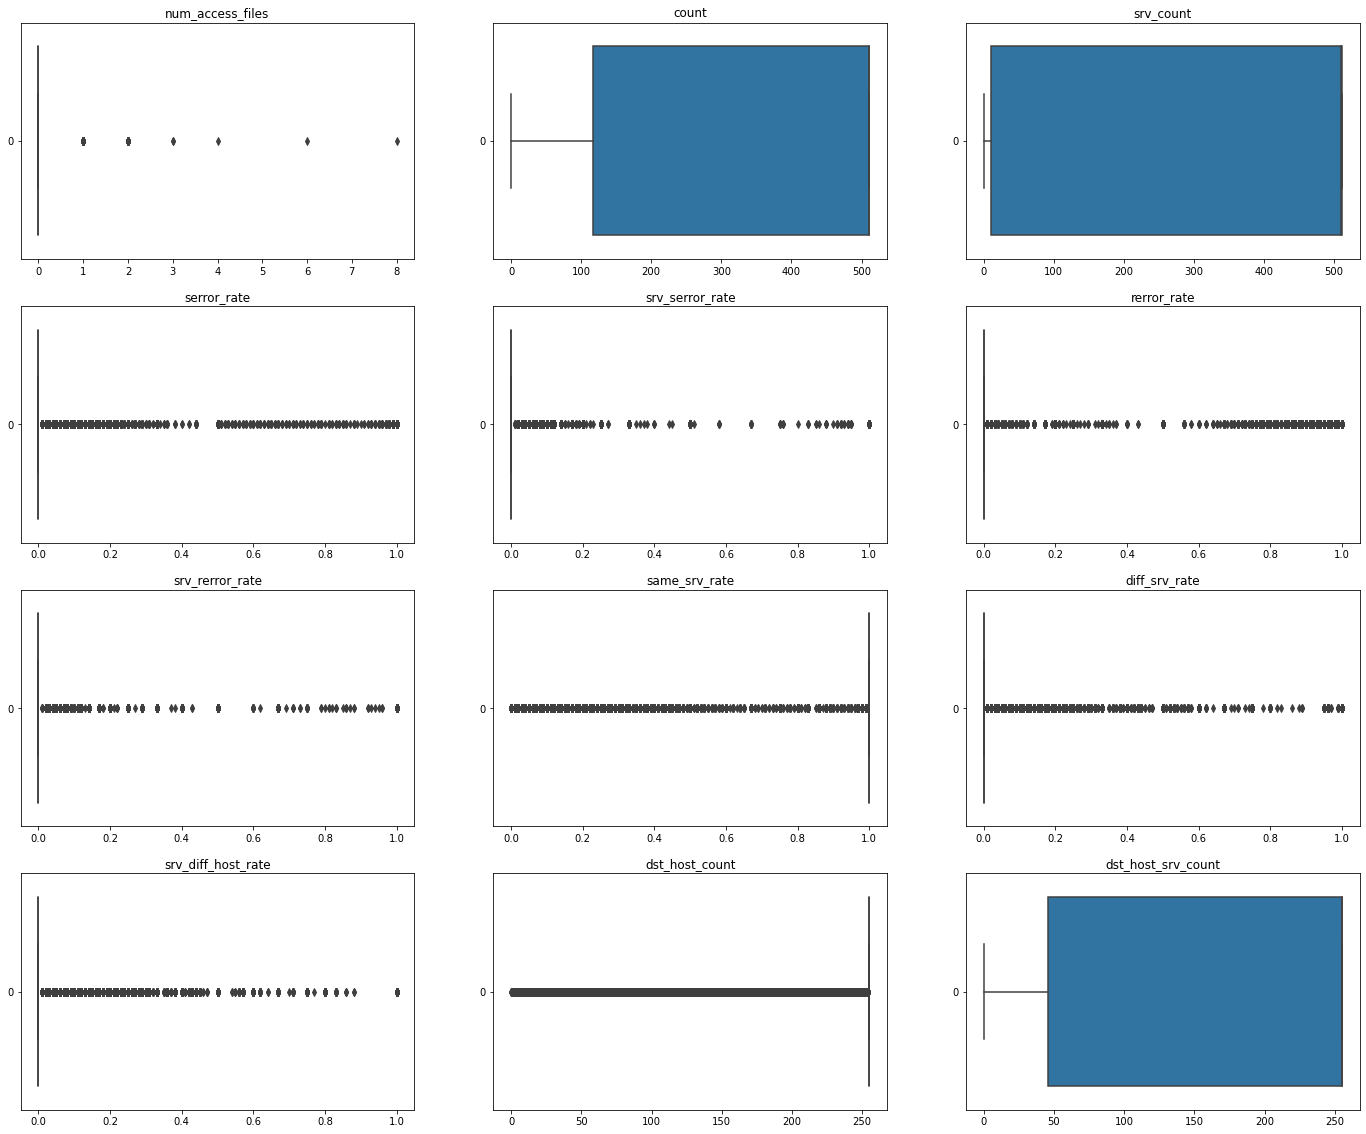

In [29]:
fig,axs = plt.subplots(nrows=4,ncols=3,figsize=(24,20))

pos = 0

for col in kdd_num_df.columns[12:24]:    
    i = pos//3
    j = pos%3 
    sns.boxplot(data=kdd_num_df[col],orient='h',ax=axs[i][j])
    axs[i][j].set_title(col)
    pos+=1

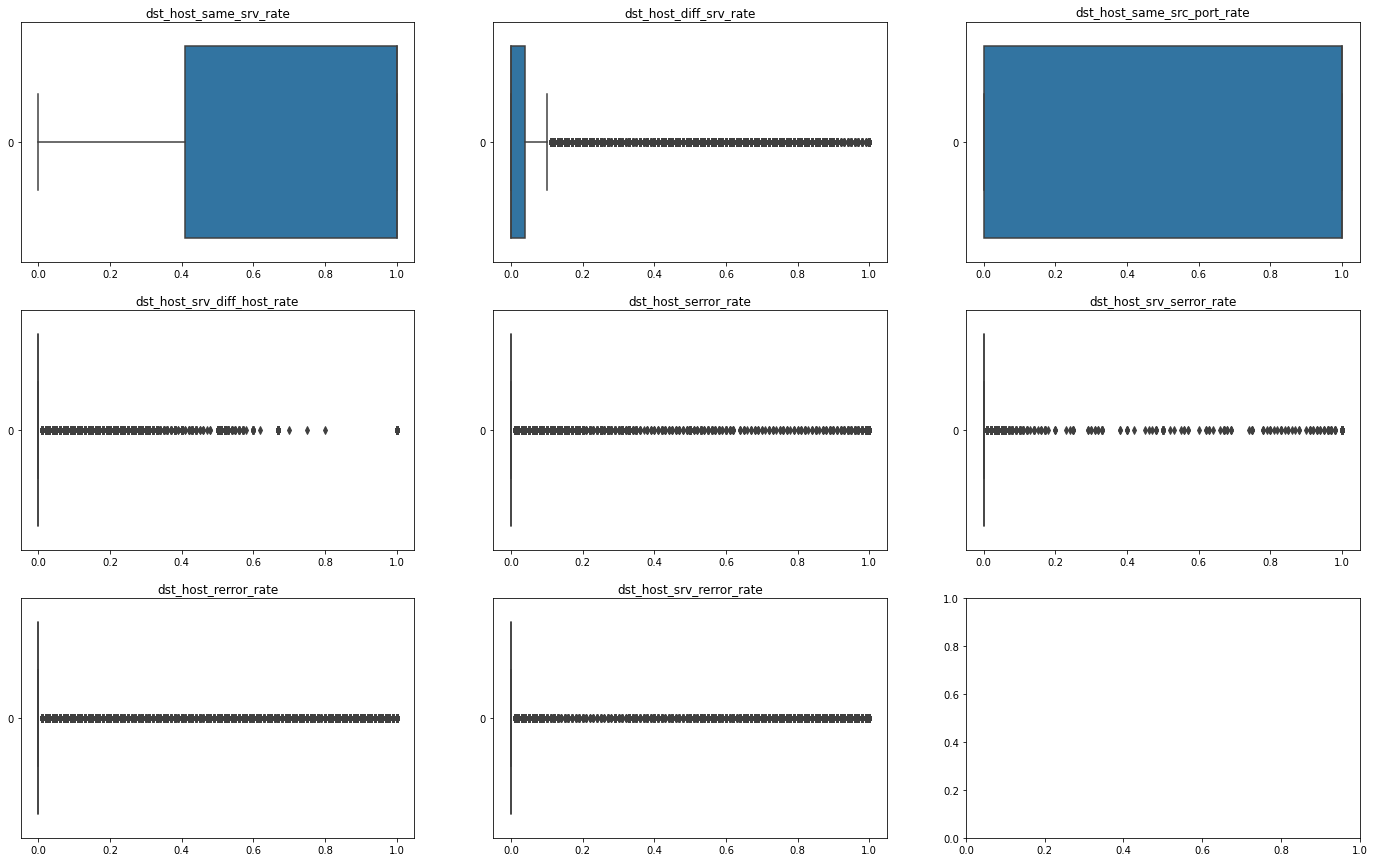

In [30]:
fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(24,15))

pos = 0

for col in kdd_num_df.columns[24:]:    
    i = pos//3
    j = pos%3 
    sns.boxplot(data=kdd_num_df[col],orient='h',ax=axs[i][j])
    axs[i][j].set_title(col)
    pos+=1

`src_bytes`, `wrong_fragment`, `urgent`, `num_failed_logins`, `loggined_in`, `root_shell`, `su_attempted`, 
`num_shells`, and `is_guest_login` stand out as the most anomalous box plots so I try 3 scalings and explore again

In [31]:
non_scale_cols = []

for col in kdd_num_df.columns:
    if len(kdd_df[col].value_counts())<4:
        non_scale_cols.append(col)
        print('---',col,'---')
        print(kdd_df[col].value_counts())
        print()

--- wrong_fragment ---
0    492783
3       970
1       268
Name: wrong_fragment, dtype: int64

--- su_attempted ---
0    494009
1         6
2         6
Name: su_attempted, dtype: int64

--- num_shells ---
0    493970
1        48
2         3
Name: num_shells, dtype: int64



In [32]:
scale_cols = []

for col in kdd_num_df.columns:
    if col not in non_scale_cols:
        scale_cols.append(col)
        
print(len(non_scale_cols),len(scale_cols))

3 29


In [33]:
kdd_std_df = kdd_num_df[scale_cols].copy()
kdd_norm_df = kdd_num_df[scale_cols].copy()
kdd_log_df = kdd_num_df[scale_cols].copy()

start = time.time()

for col in kdd_std_df:
    mu = kdd_std_df[col].mean()
    sigma = kdd_std_df[col].std()
    
    kdd_std_df[col] = (kdd_std_df[col] - mu ) / sigma
    
for col in kdd_norm_df:
    mu = kdd_norm_df[col].min()
    sigma = kdd_norm_df[col].max() - mu
    
    kdd_norm_df[col] = (kdd_norm_df[col] - mu ) / sigma
    
for col in kdd_log_df:
    kdd_log_df[col] = kdd_log_df[col].apply(lambda x: math.log(1+x))
    
end = time.time()

print('Time elapsed:', round(end-start,2), 'seconds')

Time elapsed: 6.84 seconds


Text(0.5, 1.0, 'Log')

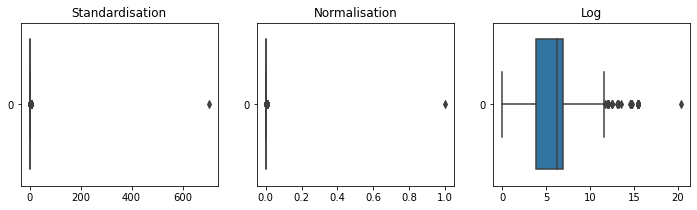

In [34]:
fig,axs = plt.subplots(figsize=(12,3),ncols=3)


sns.boxplot(data=kdd_std_df['src_bytes'],ax=axs[0],orient='h')
axs[0].set_title('Standardisation')
sns.boxplot(data=kdd_norm_df['src_bytes'],ax=axs[1],orient='h')
axs[1].set_title('Normalisation')
sns.boxplot(data=kdd_log_df['src_bytes'],ax=axs[2],orient='h')
axs[2].set_title('Log')

Standardisation keeps a somewhat similar structure as before with the maximum values still far from the min. and IQR. Normalisation is a bit better but all the non-extreme values will be essentially mapped to 0. 
To see how squished Normalisation values are near 0:

1.488371e-06    228035
0.000000e+00    115342
7.499542e-07     52774
1.514331e-07      7370
2.120063e-07      2725
                 ...  
4.095904e-06         1
4.493957e-06         1
3.455558e-06         1
8.938878e-06         1
6.801508e-06         1
Name: src_bytes, Length: 3300, dtype: int64


<AxesSubplot:>

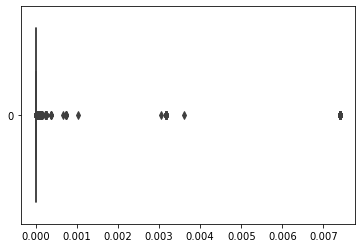

In [35]:
print(kdd_norm_df['src_bytes'].sort_values().value_counts())

sns.boxplot(data=kdd_norm_df[kdd_norm_df['src_bytes']<1]['src_bytes'],orient='h')

As a result, the log-transform seems to be the best at first glance for our scaling choice but we explore further across all 3 transforms.

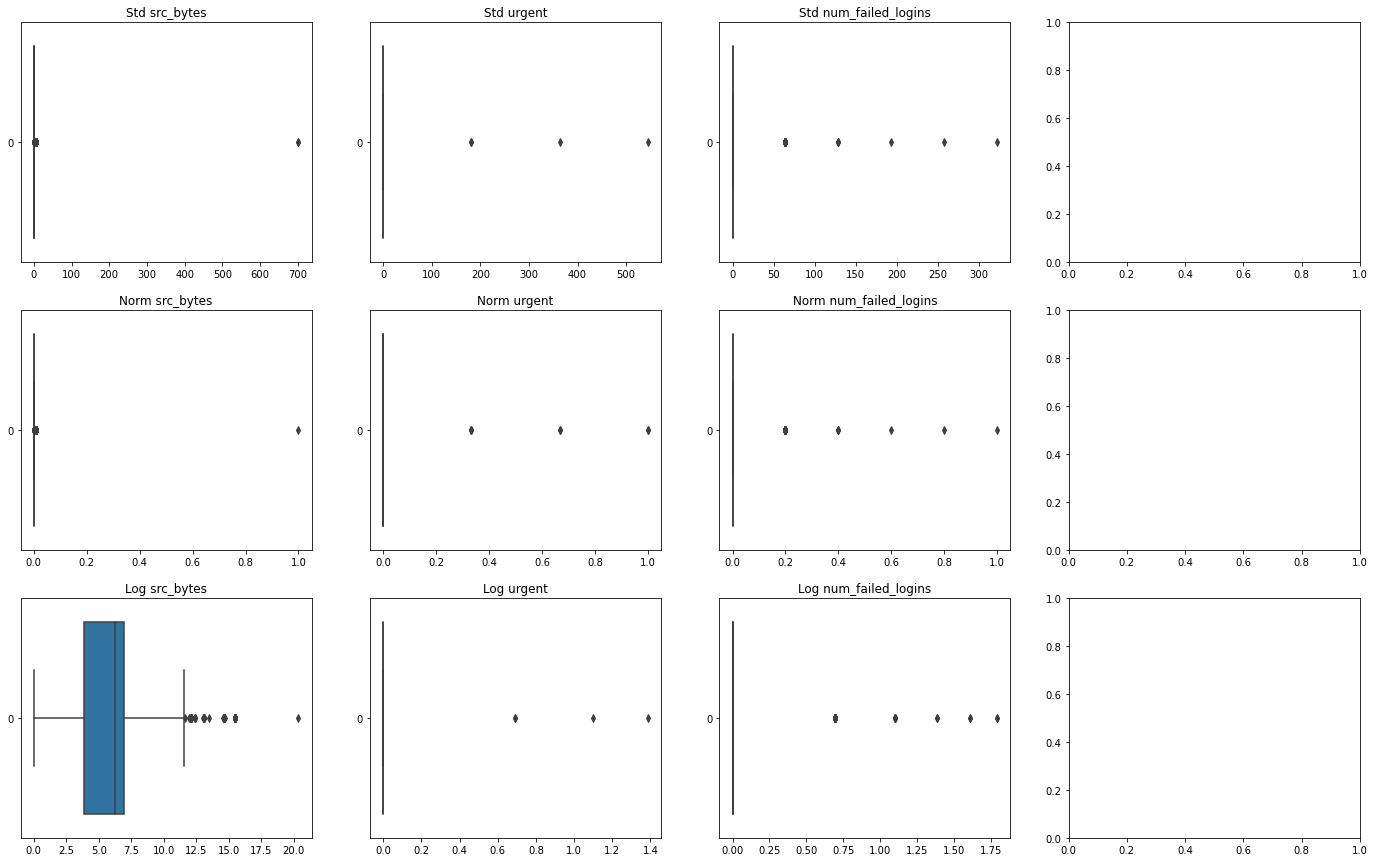

In [36]:
#these are the columns that seemed most skewed/'anomalous'
col_check = ['src_bytes', 'urgent', 'num_failed_logins']

fig, axs = plt.subplots(figsize=(24,15),nrows=3,ncols=4)   

pos = 0

#We display each row to correspond to a transform and each column to a feature
for n,col in enumerate(col_check[:4]):
    for r in range(4):
        i = pos%3
        j = n

        if i == 0:
            sns.boxplot(data=kdd_std_df[col],orient='h',ax=axs[i][j])
            axs[i][j].set_title('Std'+' '+col)
        if i == 1:
            sns.boxplot(data=kdd_norm_df[col],orient='h',ax=axs[i][j])
            axs[i][j].set_title('Norm'+' '+col)
        if i == 2:
            sns.boxplot(data=kdd_log_df[col],orient='h',ax=axs[i][j])
            axs[i][j].set_title('Log'+' '+col)

        pos+=1
        
plt.savefig('standardised_anomalies_1.png')

In [37]:
klt = kdd_log_df.describe().transpose()

We check to see if we scaled values to lie in close intervals to one another.<br></br>
**Heuristic: -1/3 to 1/3 if small values, -3 to 3 if larger values, equivalent 0 to 6.**<br></br>
All our values are non-negative, we check which ones have max above 6.

In [38]:
klt[klt['max']>6].sort_values('max',ascending=False)

,count,mean,std,min,25%,50%,75%,max
src_bytes,494021.0,4.978740,2.863505,0.0,3.828641,6.25575,6.940222,20.357082
dst_bytes,494021.0,1.182156,2.667729,0.0,0.000000,0.00000,0.000000,15.455569
duration,494021.0,0.104682,0.833807,0.0,0.000000,0.00000,0.000000,10.973872
num_root,494021.0,0.001843,0.060987,0.0,0.000000,0.00000,0.000000,6.901737
num_compromised,494021.0,0.003304,0.053720,0.0,0.000000,0.00000,0.000000,6.785588
count,494021.0,5.020404,1.882039,0.0,4.770685,6.23637,6.238325,6.238325
srv_count,494021.0,4.427168,2.154978,0.0,2.397895,6.23637,6.238325,6.238325


There may be justification to scale these values more so that they are closer to one another/more similar. Normalisation does this (in fact, it will set all our values to lie strictly in [0,1]) but we end up with very small values near 0 for most our data/quantiles when we have features that have largely skewed data e.g. `src_bytes`

However, I decide to keep the log-transform as is and not scale it any further for now and instead explore how it will perform on a number of different classifiers.

In [39]:
int_cols = [col for col in kdd_df.columns if col not in kdd_log_df.columns and kdd_df[col].dtype=='int64']
int_cols

['wrong_fragment',
 'logged_in',
 'root_shell',
 'su_attempted',
 'num_shells',
 'is_guest_login']

In [40]:
kdd_int = kdd_df[int_cols].copy()

In [41]:
kdd_log_df = kdd_log_df.merge(kdd_int,left_on=kdd_log_df.index, right_on=kdd_df.index).drop('key_0',axis=1).astype(float)

In [42]:
obj_cols = [col for col in kdd_df.columns if kdd_df[col].dtype=='object']
obj_cols = obj_cols[:-2]
obj_cols

['protocol_type', 'service', 'flag']

In [43]:
kdd_obj = kdd_df[obj_cols].copy()
kdd_obj.head()

,protocol_type,service,flag
0,tcp,http,SF
1,tcp,http,SF
2,tcp,http,SF
3,tcp,http,SF
4,tcp,http,SF


In [44]:
dum_df = pd.get_dummies(kdd_obj)

In [45]:
dum_df

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
494017,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
494018,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
494019,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [46]:
kdd_log_df = kdd_log_df.merge(dum_df,left_on=kdd_log_df.index,right_on=dum_df.index).drop('key_0',axis=1).astype(float)
kdd_log_df.head()

,duration,src_bytes,dst_bytes,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_access_files,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,5.204007,8.603554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,5.480639,6.188264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,5.463832,7.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,5.393628,7.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,5.384495,7.617268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
conn_df = kdd_df[['connection_type','connection_category']]
kdd_log_df = kdd_log_df.merge(conn_df,left_on=kdd_log_df.index,right_on=conn_df.index).drop('key_0',axis=1)
kdd_log_df.head()

,duration,src_bytes,dst_bytes,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_access_files,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,connection_type,connection_category
0,0.0,5.204007,8.603554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
1,0.0,5.480639,6.188264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
2,0.0,5.463832,7.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
3,0.0,5.393628,7.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
4,0.0,5.384495,7.617268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal


In [48]:
len(kdd_log_df.columns)

117

In [49]:
kdd_df.to_csv('kdd')

In [50]:
kdd_log_df.to_csv('kdd_log_df.csv',index=False)

In [52]:
kdd_df.to_csv('kdd_df.csv',index=False)